In [2]:
import pandas as pd

data_dir = r"C:\Users\andras.janko\Documents\CensusIncomePrediction\_data"
X_train = pd.read_csv(f"{data_dir}/X_train.csv")
X_test = pd.read_csv(f"{data_dir}/X_test.csv")
y_train = pd.read_csv(f"{data_dir}/y_train.csv").squeeze()
y_test = pd.read_csv(f"{data_dir}/y_test.csv").squeeze()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

results = {}

# 1. Baseline: always predict majority class
baseline_acc = y_test.value_counts(normalize=True).iloc[0]
print(f"=== Baseline (always predict <=50K) ===")
print(f"Accuracy: {baseline_acc:.4f}\n")

# 2. Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_proba = rf.predict_proba(X_test)[:, 1]
results['Random Forest'] = {'acc': accuracy_score(y_test, rf_pred), 'auc': roc_auc_score(y_test, rf_proba)}
print(f"=== Random Forest ===")
print(f"Accuracy: {results['Random Forest']['acc']:.4f}")
print(f"ROC AUC:  {results['Random Forest']['auc']:.4f}")
print(classification_report(y_test, rf_pred, target_names=['<=50K', '>50K']))

# 3. XGBoost
xgb = XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=6, random_state=42,
                     eval_metric='logloss')
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)
xgb_proba = xgb.predict_proba(X_test)[:, 1]
results['XGBoost'] = {'acc': accuracy_score(y_test, xgb_pred), 'auc': roc_auc_score(y_test, xgb_proba)}
print(f"=== XGBoost ===")
print(f"Accuracy: {results['XGBoost']['acc']:.4f}")
print(f"ROC AUC:  {results['XGBoost']['auc']:.4f}")
print(classification_report(y_test, xgb_pred, target_names=['<=50K', '>50K']))

# Summary
print("=== Summary ===")
print(f"{'Model':<20} {'Accuracy':<12} {'ROC AUC':<12}")
print(f"{'Baseline':<20} {baseline_acc:<12.4f} {'N/A':<12}")
for name, m in results.items():
    print(f"{name:<20} {m['acc']:<12.4f} {m['auc']:<12.4f}")

=== Baseline (always predict <=50K) ===
Accuracy: 0.7593

=== Random Forest ===
Accuracy: 0.8477
ROC AUC:  0.8912
              precision    recall  f1-score   support

       <=50K       0.88      0.92      0.90      4945
        >50K       0.71      0.62      0.66      1568

    accuracy                           0.85      6513
   macro avg       0.80      0.77      0.78      6513
weighted avg       0.84      0.85      0.84      6513

=== XGBoost ===
Accuracy: 0.8729
ROC AUC:  0.9245
              precision    recall  f1-score   support

       <=50K       0.90      0.94      0.92      4945
        >50K       0.78      0.65      0.71      1568

    accuracy                           0.87      6513
   macro avg       0.84      0.80      0.82      6513
weighted avg       0.87      0.87      0.87      6513

=== Summary ===
Model                Accuracy     ROC AUC     
Baseline             0.7593       N/A         
Random Forest        0.8477       0.8912      
XGBoost              0.87

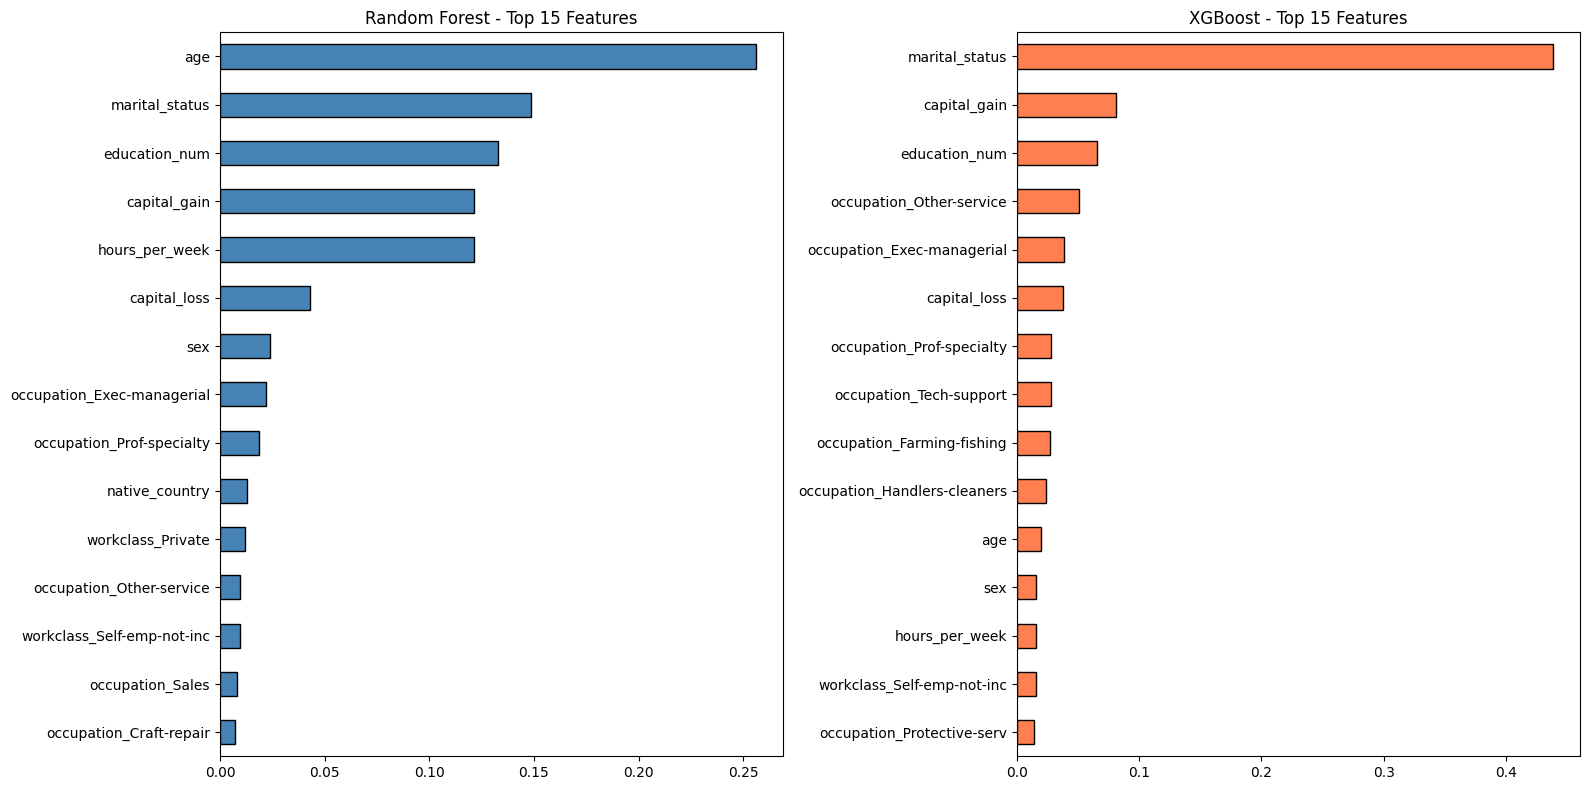

=== Top 10 Features ===
Rank   Random Forest                  XGBoost                       
1      age                       0.2562   marital_status            0.4385
2      marital_status            0.1484   capital_gain              0.0813
3      education_num             0.1327   education_num             0.0656
4      capital_gain              0.1216   occupation_Other-service  0.0508
5      hours_per_week            0.1216   occupation_Exec-managerial 0.0384
6      capital_loss              0.0431   capital_loss              0.0373
7      sex                       0.0240   occupation_Prof-specialty 0.0281
8      occupation_Exec-managerial 0.0219   occupation_Tech-support   0.0277
9      occupation_Prof-specialty 0.0185   occupation_Farming-fishing 0.0272
10     native_country            0.0131   occupation_Handlers-cleaners 0.0241


In [5]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Random Forest feature importance
rf_imp = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=True)
rf_imp.tail(15).plot.barh(ax=axes[0], color='steelblue', edgecolor='black')
axes[0].set_title('Random Forest - Top 15 Features')

# XGBoost feature importance
xgb_imp = pd.Series(xgb.feature_importances_, index=X_train.columns).sort_values(ascending=True)
xgb_imp.tail(15).plot.barh(ax=axes[1], color='coral', edgecolor='black')
axes[1].set_title('XGBoost - Top 15 Features')

plt.tight_layout()
plt.show()

# Text version
print("=== Top 10 Features ===")
print(f"{'Rank':<6} {'Random Forest':<30} {'XGBoost':<30}")
rf_top = rf_imp.sort_values(ascending=False).head(10)
xgb_top = xgb_imp.sort_values(ascending=False).head(10)
for i in range(10):
    print(f"{i+1:<6} {rf_top.index[i]:<25} {rf_top.values[i]:.4f}   {xgb_top.index[i]:<25} {xgb_top.values[i]:.4f}")

In [ ]:
from sklearn.metrics import precision_recall_curve

# XGBoost with scale_pos_weight to handle imbalance
# ratio of negative to positive class
scale_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
print(f"Class imbalance ratio: {scale_ratio:.2f}\n")

xgb_balanced = XGBClassifier(
    n_estimators=200, learning_rate=0.1, max_depth=6,
    scale_pos_weight=scale_ratio, random_state=42, eval_metric='logloss'
)
xgb_balanced.fit(X_train, y_train)
xgb_bal_pred = xgb_balanced.predict(X_test)
xgb_bal_proba = xgb_balanced.predict_proba(X_test)[:, 1]

print("=== XGBoost (balanced) ===")
print(f"Accuracy: {accuracy_score(y_test, xgb_bal_pred):.4f}")
print(f"ROC AUC:  {roc_auc_score(y_test, xgb_bal_proba):.4f}")
print(classification_report(y_test, xgb_bal_pred, target_names=['<=50K', '>50K']))

# Threshold tuning on original XGBoost
print("=== Original XGBoost - Threshold Analysis ===")
for threshold in [0.3, 0.35, 0.4, 0.45, 0.5]:
    preds = (xgb_proba >= threshold).astype(int)
    acc = accuracy_score(y_test, preds)
    prec = precision_recall_curve(y_test, xgb_proba)
    report = classification_report(y_test, preds, target_names=['<=50K', '>50K'], output_dict=True)
    print(f"Threshold {threshold}: Acc={acc:.4f}  >50K Precision={report['>50K']['precision']:.3f}  >50K Recall={report['>50K']['recall']:.3f}  >50K F1={report['>50K']['f1-score']:.3f}")

Class imbalance ratio: 3.15

=== XGBoost (balanced) ===
Accuracy: 0.8314
ROC AUC:  0.9235
              precision    recall  f1-score   support

       <=50K       0.94      0.83      0.88      4945
        >50K       0.61      0.85      0.71      1568

    accuracy                           0.83      6513
   macro avg       0.78      0.84      0.79      6513
weighted avg       0.86      0.83      0.84      6513

=== Original XGBoost - Threshold Analysis ===
Threshold 0.3: Acc=0.8445  >50K Precision=0.638  >50K Recall=0.818  >50K F1=0.717
Threshold 0.35: Acc=0.8563  >50K Precision=0.675  >50K Recall=0.779  >50K F1=0.723
Threshold 0.4: Acc=0.8657  >50K Precision=0.714  >50K Recall=0.737  >50K F1=0.725
Threshold 0.45: Acc=0.8706  >50K Precision=0.752  >50K Recall=0.691  >50K F1=0.720
Threshold 0.5: Acc=0.8729  >50K Precision=0.784  >50K Recall=0.652  >50K F1=0.712


In [ ]:
import optuna
from sklearn.model_selection import cross_val_score
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 600, step=50),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10, log=True),
    }

    model = XGBClassifier(**params, random_state=42, eval_metric='logloss', n_jobs=-1)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)
    return scores.mean()

sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=100, show_progress_bar=True)

print(f"Best ROC AUC (CV): {study.best_value:.4f}")
print(f"Best params:\n{study.best_params}")

# Evaluate best model on test set
best_xgb = XGBClassifier(**study.best_params, random_state=42, eval_metric='logloss', n_jobs=-1)
best_xgb.fit(X_train, y_train)
best_pred = best_xgb.predict(X_test)
best_proba = best_xgb.predict_proba(X_test)[:, 1]

print(f"\n=== Best XGBoost (Optuna) on Test Set ===")
print(f"Accuracy: {accuracy_score(y_test, best_pred):.4f}")
print(f"ROC AUC:  {roc_auc_score(y_test, best_proba):.4f}")
print(classification_report(y_test, best_pred, target_names=['<=50K', '>50K']))

  0%|          | 0/100 [00:00<?, ?it/s]

Best trial: 94. Best value: 0.929672: 100%|██████████| 100/100 [01:40<00:00,  1.01s/it]


Best ROC AUC (CV): 0.9297
Best params:
{'max_depth': 5, 'learning_rate': 0.055552850564672865, 'n_estimators': 250, 'min_child_weight': 1, 'subsample': 0.9551956629000853, 'colsample_bytree': 0.74244249119936, 'gamma': 0.28361083099106926, 'reg_alpha': 3.873817893843489e-05, 'reg_lambda': 0.00034051513286596845}

=== Best XGBoost (Optuna) on Test Set ===
Accuracy: 0.8713
ROC AUC:  0.9243
              precision    recall  f1-score   support

       <=50K       0.89      0.94      0.92      4945
        >50K       0.79      0.64      0.71      1568

    accuracy                           0.87      6513
   macro avg       0.84      0.79      0.81      6513
weighted avg       0.87      0.87      0.87      6513

